In [2]:
import numpy as np

from qiskit import Aer, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from qiskit.extensions import UnitaryGate

import numpy as np
from scipy.linalg import expm, eig
import matplotlib.pyplot as plt

## Exercise
Perform quantum phase estimation (QPE) to find the ground state energy of the Hamiltonian provided below. We provide you with the Hamiltonian of a 2-site transverse field Ising model that we have seen in previous exercises. We added a diagonal offset to the Hamiltonian for convenience, shifting its spectrum so that all eigenvalues are positive.

Your task is to set the total evolution time of the unitary time evolution operator needed for QPE or, equivalently, an energy normalization such that the Hamiltonian's spectrum is rescaled to within the range [0, 2pi].
- State your choice of t and the rescaling of the energy. You can try different values but you should clearly state which one you think is best and why.
- Perform the QPE using the `AerSimulator` (simulated measurements) with different number of ancillas, $r \in \{2, \ldots, 10\}$ ($r=10$ ancillas should still be pretty fast to simulate. However, if your machine is not able to handle it, go up to the value maximum possible number of ancillas and cleanly print the results.)
- For each ancilla value, extract the energy first reading out the binary string and then apply the suitable conversion to a decimal representation.
- Plot the value of the energy extracted using the QPE as a function of $r$ and plot the error with the exact ground state. (In addition, you can plot the energy and error corresponding to the second most likely bit string)
- Check if the QPE energies are consistent with the exact value obtained through exact diagonalization

In [3]:
H_ising = np.array(
    [[-1, -1, -1,  0],
    [-1,  1,  0, -1],
    [-1,  0,  1, -1],
    [ 0, -1, -1, -1]], dtype='complex'
)

system_qubits = 2

diag_offset = np.array(
    [[1, 0, 0,  0],
    [0,  1,  0, 0],
    [0,  0,  1, 0],
    [ 0, 0, 0, 1]], dtype='complex'
)

H = (H_ising + 3*diag_offset)

In [4]:
eigVals, eigVecs = eig(H)
idx = eigVals.argsort()[::-1]   
eigVals = eigVals[idx]
eigenVectors = eigVecs[:,idx]
gs_exact = min(eigVals)
print(f"eigen values:\n{eigVals}\n")
print(f"eigen vectors:\n{eigVecs}\n")

print(f"max eigenvalue: {np.max(eigVals)}")
print(f"min eigenvalue: {gs_exact}")

eigen values:
[5.23606798+0.j 4.        +0.j 2.        +0.j 0.76393202+0.j]

eigen vectors:
[[-3.71748034e-01+0.j  7.07106781e-01+0.j  6.01500955e-01+0.j
  -2.22044605e-16-0.j]
 [ 6.01500955e-01+0.j -1.34163951e-16-0.j  3.71748034e-01+0.j
   7.07106781e-01+0.j]
 [ 6.01500955e-01+0.j -2.22634849e-16-0.j  3.71748034e-01+0.j
  -7.07106781e-01-0.j]
 [-3.71748034e-01+0.j -7.07106781e-01-0.j  6.01500955e-01+0.j
  -4.44089210e-16-0.j]]

max eigenvalue: (5.236067977499785+0j)
min eigenvalue: (0.7639320225002101+0j)


We define the "evolution time" (note that we are not really doing time evolution here, it's just a parameter) and the controlled unitary gate. In practice, we would need an approximate algorithm to implement this unitary (such as Trotterization). Here, we simply turn the matrix into a gate.

In [8]:
# We determine the E_{max} by finding the maximum eigenvalue of the Hamiltonian
E_max = np.max(eigVals)

# And the same for the min
E_min = np.min(eigVals)

# We can determine t using the formula from the notes
t = 2 * np.pi / (E_max - E_min)

print(f"t: {t}")

t: (1.4049629462081465+0j)


In [9]:
U = expm(1.j * t * H)

Ugate = UnitaryGate(U)
print(np.allclose(U, Ugate.params[0]), "\n")

qc = QuantumCircuit(system_qubits, name="exp(iHt)")
qc.append(Ugate, [0, 1])

print(f"unitary gate from matrix in terms of rotational and two-qubit gates")
print(qc.decompose(), "\n")

CUgate = qc.to_gate().control(1)

print(f"controlled version of that unitary gate (note, this is NOT the Trotter circuit)")
qc = QuantumCircuit(3)
qc.append(CUgate, [0,1, 2])
print(qc.decompose())


True 

unitary gate from matrix in terms of rotational and two-qubit gates
global phase: 1.8061
     ┌─────────────────────┐         ┌──────────────────┐         »
q_0: ┤ U(0,-3.0437,1.4729) ├──■──────┤ U(1.7366,-π,π/2) ├──────■──»
     └─┬──────────────────┬┘┌─┴─┐┌───┴──────────────────┴───┐┌─┴─┐»
q_1: ──┤ U(0.40375,π/2,0) ├─┤ X ├┤ U(1.2644,-1.1523,2.8282) ├┤ X ├»
       └──────────────────┘ └───┘└──────────────────────────┘└───┘»
«     ┌─────────────────────┐
«q_0: ┤ U(0,-1.8708,1.8708) ├
«     └─┬──────────────────┬┘
«q_1: ──┤ U(1.167,-π,-π/2) ├─
«       └──────────────────┘  

controlled version of that unitary gate (note, this is NOT the Trotter circuit)
                                                                               »
q_0: ────────────■──────────────────────■─────────────■────────────■───────────»
     ┌───────────┴───────────┐          │             │  ┌─────────┴──────────┐»
q_1: ┤ U(0,-3.0437,1.4729,0) ├──────────┼─────────────■──┤ U(1.7366,-π,π/2,0) ├»
     └──

We define a method to get the QPE circuit (as in the tutorial) as well as a method to transform the binary phase into a decimal phase.

In [10]:
def get_qpe_circ(ancilla_reg, system_reg, classical_reg, init_circ):
    num_ancillas = ancilla_reg.size
    
    qpe_circ = QuantumCircuit(
        ancilla_reg, system_reg,
        classical_reg
    )

    # initialize system in approx eigenstate |psi>:
    qpe_circ.append(init_circ, system_reg)
    qpe_circ.barrier()

    # initialize num_ancillas in equal superposition
    for qubit in range(num_ancillas):
        qpe_circ.h(qubit)

    qpe_circ.barrier()

    # controlled unitaries
    reps = 1
    for a in range(num_ancillas):
        for _ in range(reps):
            qpe_circ.append(CUgate, [ancilla_reg[a], system_reg[0], system_reg[1]])
        reps *= 2
        qpe_circ.barrier()

    # inverse Quantum Fourier transform
    qpe_circ.append(QFT(num_ancillas, inverse=True), ancilla_reg)

    return qpe_circ


In [11]:
def phase_bin_to_dec(bitstring):

    dec = 0

    for i in range(len(bitstring)):
        dec += int(bitstring[i]) * 2**-(i+1)
    
    return dec

We can check the circuit for 2 ancillas

In [12]:
# Create and set up circuit
ancillas = 2

anc_reg = QuantumRegister(ancillas, "anc")
sys_reg = QuantumRegister(system_qubits, "sys")
creg = ClassicalRegister(ancillas, "c")

init_circ = QuantumCircuit(sys_reg, name="init")
init_circ.h(sys_reg[0])
init_circ.ry(np.pi / 6, sys_reg[1])
init_circ.cx(sys_reg[0], sys_reg[1])

qpe_circ = get_qpe_circ(anc_reg, sys_reg, creg, init_circ)

In [13]:
qpe_circ.measure(anc_reg, creg)

### The actual simulation
Now we run QPE for the desired numbers of ancillas, simulate the circuit measurements and store the resulting count dictionaries.

In [14]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096

ancillas_list = list(range(2, 10 + 1))
counts = {}
for ancillas in ancillas_list:
    print(f"simulating {ancillas} ancillas")
    anc_reg = QuantumRegister(ancillas, "anc")
    sys_reg = QuantumRegister(system_qubits, "sys")
    creg = ClassicalRegister(ancillas, "c")

    init_circ = QuantumCircuit(sys_reg, name="init")
    init_circ.h(sys_reg[0])
    init_circ.ry(np.pi / 6, sys_reg[1])
    init_circ.cx(sys_reg[0], sys_reg[1])

    qpe_circ = get_qpe_circ(anc_reg, sys_reg, creg, init_circ)

    qpe_circ.measure(anc_reg, creg)

    t_qc = transpile(qpe_circ, aer_sim)
    results = aer_sim.run(t_qc, shots=shots).result()
    counts[ancillas] = results.get_counts()

simulating 2 ancillas
simulating 3 ancillas
simulating 4 ancillas
simulating 5 ancillas
simulating 6 ancillas
simulating 7 ancillas
simulating 8 ancillas
simulating 9 ancillas
simulating 10 ancillas


### Computing the decimal representation of the most probable phases from the counts

In [15]:
# YOUR CODE:
# Compute the correct phases from your measured bit strings
phase_dec = []
second_phase_dec = []

for ancillas in ancillas_list:
    phase_dec.append(phase_bin_to_dec(list(counts[ancillas].keys())[0]))
    second_phase_dec.append(phase_bin_to_dec(list(counts[ancillas].keys())[1]))

Finally, we plot the results

/home/ar/miniconda3/envs/aqa/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ar/miniconda3/envs/aqa/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


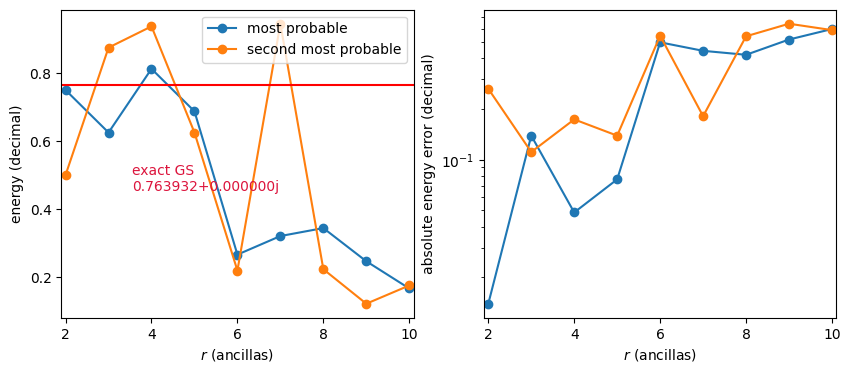

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
axs[0].plot(ancillas_list, phase_dec, marker="o", label="most probable")
axs[0].plot(ancillas_list, second_phase_dec, marker="o", label="second most probable")
axs[0].set_xlabel(rf"$r$ (ancillas)")
axs[0].set_ylabel(rf"energy (decimal)")
axs[0].set_xlim(1.9, 10.1)
# axs[0].set_ylim() # NOTE depending on your results
axs[0].legend()

axs[0].plot([-1, 20], [gs_exact, gs_exact], color="red")
axs[0].text(
    0.2, 0.5,
    "exact GS" + "\n" + f"{gs_exact:.6f}",
    color="crimson",
    transform=axs[0].transAxes,
    # fontsize=,
    verticalalignment='top'
)

axs[1].plot(ancillas_list, np.abs(phase_dec - gs_exact), marker="o")
axs[1].plot(ancillas_list, np.abs(second_phase_dec - gs_exact), marker="o")
axs[1].set_xlabel(rf"$r$ (ancillas)")
axs[1].set_ylabel(rf"absolute energy error (decimal)")
axs[1].set_yscale("log")

plt.show()